# Prosjektoppgave GEO9300 - Hydrologic regime in Vosso and changes over time. 

#### Background: https://www.nrk.no/vestland/pa-voss-har-det-vaert-fem-20-arsflommer-siste-atte-ar-1.16178538. 

#### Voss has experienced five 20 year floods in the past 8 years (NRK, 2022). They claim the climate expected in 2100 has already reached them. Is that correct? How much has the hydrology changed the past 30 years for Voss? 

#### Climate scenario modeling for Voss estimate that todays 1000 yr flood will be a 200 year flood in 2100. 

#### Q:Can we see a change in the hydrologic regime of Voss the past 30 years, compared to the previous normal period? 

##### Calculate basic statistic: yearly and monthly? 
##### Determine high and low flow pulses: 75 % for high flow and 25 % for low flow.
##### Determine high and low flow durations. 
##### Is there a significant difference in MAD (Mean annual discharge)
##### Libraries: HydroBox / Hydropy

#### Flood frequence analysis? 
#### Q: What is the probability of getting 4 (or 5) 20 year flood in 8 years? 

#### Machine learning
#### Can we simulate future discharge using a ML-model?
##### Input: climate data, CC (from GIS), ...  


In [3]:
#Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
import math

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Prepare data and describe data
#### First we need to prepare the data. We use data from Bulken gauge station. Load using pd.read and create two separate datasets to compare. 

#### We have three datasets
#### 1) Discharge data (hourly)
#### 2) Flood values
#### 3) Percentiles

In [4]:
#1)  Read the discharge data
vf = pd.read_csv('62.5.0-Vannføring-dogn-v1.csv', delimiter=';', on_bad_lines='skip', skiprows=[0])

# Convert comma to period in Vannføring column and convert to float
vf['Vannføring'] = vf['Vannføring'].str.replace(',', '.').astype(float)

# Split into two time periods
vf1 = vf[(vf['Tidspunkt'] >= '1991-01-01') & (vf['Tidspunkt'] <= '2020-12-31')].copy()
vf2 = vf[(vf['Tidspunkt'] >= '1961-01-01') & (vf['Tidspunkt'] <= '1990-12-31')].copy()

# Convert Tidspunkt to datetime
vf1['Tidspunkt'] = pd.to_datetime(vf1['Tidspunkt'])
vf2['Tidspunkt'] = pd.to_datetime(vf2['Tidspunkt'])

# Set Tidspunkt as index for both dataframes
vf1.set_index('Tidspunkt', inplace=True)
vf2.set_index('Tidspunkt', inplace=True)

# Sort by time
vf1.sort_index(inplace=True)
vf2.sort_index(inplace=True)

# Display the results
print("\nFirst rows of vf1 (1991-2020):")
print(vf1.head())
print("\nFirst rows of vf2 (1961-1990):")
print(vf2.head())

#2) Read flood values
flomverdier = pd.read_csv('flomverdier.csv', delimiter=';', on_bad_lines='skip', skiprows=[0])
print(flomverdier.head())



First rows of vf1 (1991-2020):
                           Vannføring  Korrigert  Kontrollert
Tidspunkt                                                    
1991-01-01 11:00:00+00:00    27.90077          0            3
1991-01-02 11:00:00+00:00    24.30701          0            3
1991-01-03 11:00:00+00:00    23.61584          0            3
1991-01-04 11:00:00+00:00    22.93392          0            3
1991-01-05 11:00:00+00:00    22.26125          0            3

First rows of vf2 (1961-1990):
                           Vannføring  Korrigert  Kontrollert
Tidspunkt                                                    
1961-01-01 11:00:00+00:00    8.919145          0            3
1961-01-02 11:00:00+00:00    8.681128          0            3
1961-01-03 11:00:00+00:00    9.161231          0            3
1961-01-04 11:00:00+00:00    8.681128          0            3
1961-01-05 11:00:00+00:00    7.551074          0            3
        Middelflom  400
0   Flomverdi 5 år  470
1  Flomverdi 10 år  

### Visialize the data. 


#### Discharge data. 

Probability density function of a continuous random variable. 

Must be f(x) >= 0 for all xi.
Integral of f(x) dx = 1 for the whole range. 

Remember: continuous functions have probability densitys. 


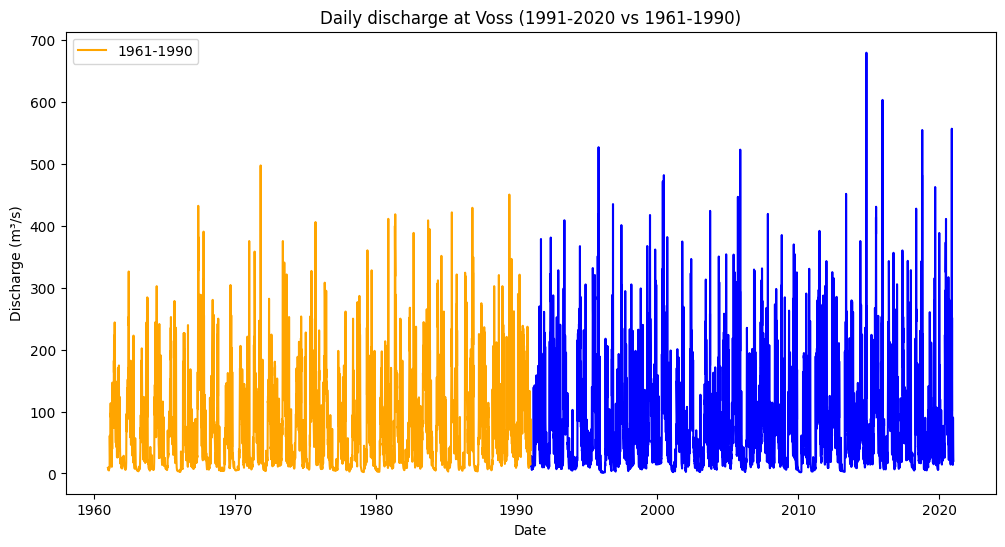

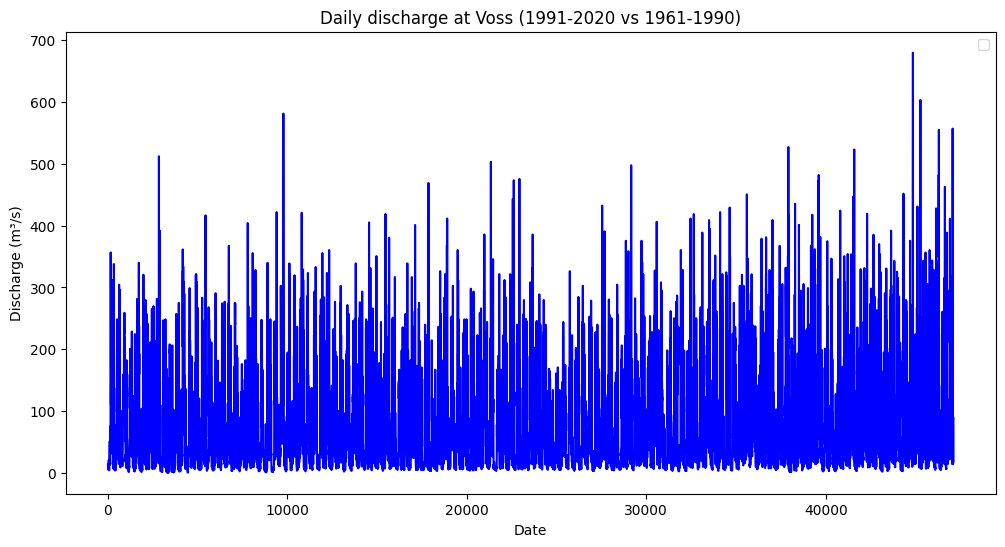

In [37]:
#Plot visualizing the timeseries. 
plt.figure(figsize=(12,6))
plt.plot(vf1['Vannføring'], color='blue')
plt.plot(vf2['Vannføring'], label='1961-1990', color='orange')
plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.title('Daily discharge at Voss (1991-2020 vs 1961-1990)')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(vf['Vannføring'], color='blue')
#plt.plot(vf2['Vannføring'], label='1961-1990', color='orange')
plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.title('Daily discharge at Voss (1991-2020 vs 1961-1990)')
plt.legend()
plt.show()


Just from looking at the graph, we notice that there are a couple higher flood peaks in the later period than the first. 

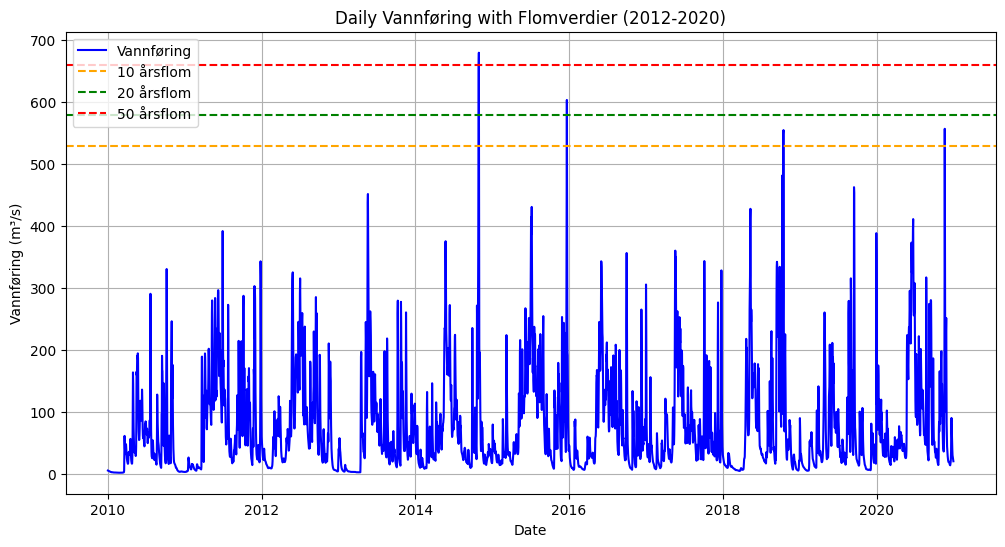

In [38]:
#Plot 2012-2020 with flomverdier
plt.figure(figsize=(12,6))

# Filter data for 2012-2020
vf1_filtered = vf1['2010':'2020']  # Using pandas datetime slicing

# Plot the filtered data
plt.plot(vf1_filtered['Vannføring'], color='blue', label='Vannføring')

# Add horizontal lines
plt.axhline(y=530, color='orange', linestyle='--', label='10 årsflom')
plt.axhline(y=580, color='g', linestyle='--', label='20 årsflom')
plt.axhline(y=660, color='r', linestyle='--', label='50 årsflom')

plt.xlabel('Date')
plt.ylabel('Vannføring (m³/s)')
plt.title('Daily Vannføring with Flomverdier (2012-2020)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

#NB: we have daily data but the flood values are for instantaneous peak discharge.

### DISTRIBUTION OF DATA AND CHECK FOR LINEARITY

#### Is the data normally distributed? What is the mean and std of each population? 

#### Q: Why is this important? 

"Hydrologists are often faced with large quantities of data. Since it is difficult to grasp the total data
picture from tabulation, a useful first step in data analysis is to use graphical procedures. Frequency
histogram is a graphical presentation of the data. This is done by grouping the data into classes and
then plotting a bar graph with the number or the relative frequency (proportion) of observations in a
class versus the midpoint (called class mark) of the class interval.
14
Cumulative frequency distribution shows the frequency of events less than (greater than) some
given value. They are formed by ranking the data from the smallest (largest) to the largest
(smallest), dividing the rank by the number of data points and plotting this ratio against the
corresponding data value" (Compendium)

#### Normal distribution

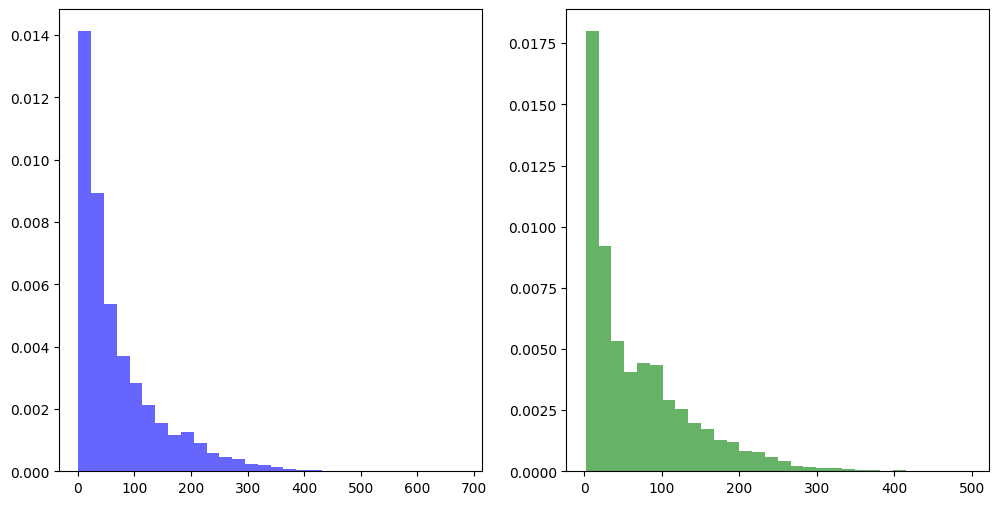

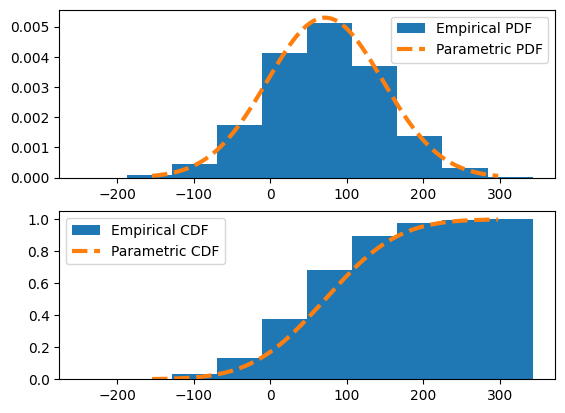

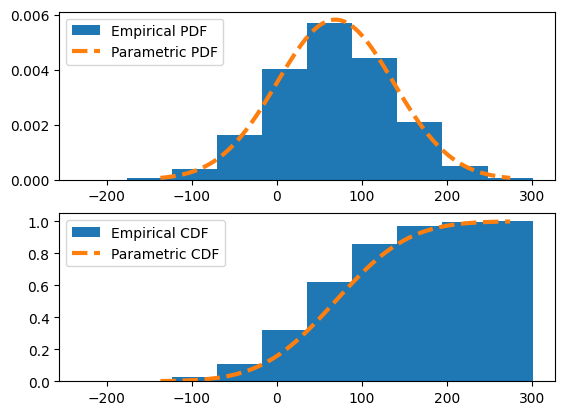

In [40]:
#Plot histogram of vf1 and vf2
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.hist(vf1['Vannføring'], bins=30, density=True, alpha=0.6, color='b')


plt.subplot(1, 2, 2)
plt.hist(vf2['Vannføring'], bins=30, density=True, alpha=0.6, color='g')

# Plot the normal distribution curve and check how our generated sample fit the curve

population_mean = vf1['Vannføring'].mean()
population_std = vf1['Vannføring'].std()
samplesize= len(vf1)

rv1 = np.random.normal(loc=population_mean, scale=population_std, size=samplesize)

fig=plt.figure()
ax1=fig.add_subplot(211) #for pdfs
ax2=fig.add_subplot(212, sharex=ax1) #for cdfs

ax1.hist(rv1, density = True, label='Empirical PDF')
ax2.hist(rv1, density = True, cumulative=True, label='Empirical CDF')

# To plot the underlaying Gaussian, we use the stats package
x = np.linspace(population_mean-3*population_std,population_mean+3*population_std,1000)
ax1.plot(x, stats.norm.pdf(x, population_mean, population_std), '--', linewidth=3, label='Parametric PDF')
ax1.legend()

ax2.plot(x, stats.norm.cdf(x, population_mean, population_std), '--', linewidth=3, label='Parametric CDF')
ax2.legend()

# Plot the normal distribution curve and check how our generated sample fit the curve

population_mean = vf2['Vannføring'].mean()
population_std = vf2['Vannføring'].std()
samplesize= len(vf2)

rv1 = np.random.normal(loc=population_mean, scale=population_std, size=samplesize)

fig=plt.figure()
ax1=fig.add_subplot(211) #for pdfs
ax2=fig.add_subplot(212, sharex=ax1) #for cdfs

ax1.hist(rv1, density = True, label='Empirical PDF')
ax2.hist(rv1, density = True, cumulative=True, label='Empirical CDF')

# To plot the underlaying Gaussian, we use the stats package
x = np.linspace(population_mean-3*population_std,population_mean+3*population_std,100)
ax1.plot(x, stats.norm.pdf(x, population_mean, population_std), '--', linewidth=3, label='Parametric PDF')
ax1.legend()

ax2.plot(x, stats.norm.cdf(x, population_mean, population_std), '--', linewidth=3, label='Parametric CDF')
ax2.legend()

#### Properties

he coefficient of variation measures the spread of a set of data as a proportion of its mean. It is
often expressed as a percentage. It is dimensionless, so it can be used for cross comparison, i.e.
for comparison of the variability of the same variable at different places, etc.
It is the ratio of the sample standard deviation to the sample mean:

In [41]:
#Properties of random variables. 

#Central tendency measures: mean, median, mode
mean_vf1 = vf1['Vannføring'].mean()
median_vf1 = vf1['Vannføring'].median()
mode_vf1 = vf1['Vannføring'].mode()[0] 

print("Mean:", mean_vf1, "Median", median_vf1, "Mode", mode_vf1)

mean_vf2 = vf2['Vannføring'].mean()
median_vf2 = vf2['Vannføring'].median()
mode_vf2 = vf2['Vannføring'].mode()[0]

print("Mean", mean_vf2, "Median", median_vf2,"Mode", mode_vf2)

#Dispersion measures: variance, standard deviation, range, interquartile range
variance_vf1 = vf1['Vannføring'].var()
std_dev_vf1 = vf1['Vannføring'].std()
range_vf1 = vf1['Vannføring'].max() - vf1['Vannføring'].min()
#iqr_vf1 = vf1['Vannføring'].quantile(0.75) - vf1['Vannføring'].quantile(0.25)   
print("Variance:", variance_vf1, "Std:", std_dev_vf1, "Range:", range_vf1, "Coeff of variation:", std_dev_vf1/mean_vf1)

variance_vf2 = vf2['Vannføring'].var()
std_dev_vf2 = vf2['Vannføring'].std()
range_vf2 = vf2['Vannføring'].max() - vf2['Vannføring'].min()
#iqr_vf1 = vf1['Vannføring'].quantile(0.75) - vf1['Vannføring'].quantile(0.25)   
print("Variance:", variance_vf2, "Std:", std_dev_vf2, "Range:", range_vf2, "Coeff of variation:", std_dev_vf2/mean_vf2)

#Symmertry measures: skewness, kurtosis
skewness_vf1 = vf1['Vannføring'].skew()
kurtosis_vf1 = vf1['Vannføring'].kurtosis()
print("Skewness:", skewness_vf1, "Kurtosis:", kurtosis_vf1) 
skewness_vf2 = vf2['Vannføring'].skew()
kurtosis_vf2 = vf2['Vannføring'].kurtosis()
print("Skewness:", skewness_vf2, "Kurtosis:", kurtosis_vf2)

Mean: 71.57862097426302 Median 43.4978 Mode 13.29744
Mean 68.8417495530303 Median 43.801 Mode 17.70476
Variance: 5672.706418895384 Std: 75.31737129570696 Range: 678.837531 Coeff of variation: 1.052232779432678
Variance: 4701.3333918369835 Std: 68.566270073827 Range: 495.598459 Coeff of variation: 0.9959983660933677
Skewness: 1.8813262175851566 Kurtosis: 4.463582936306628
Skewness: 1.469787147454497 Kurtosis: 2.2931018262239125


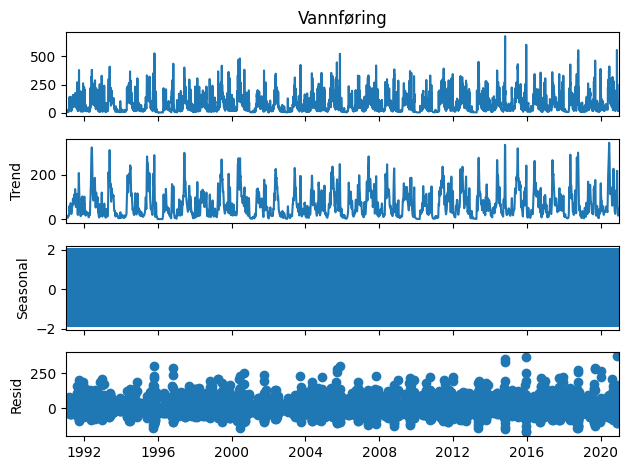

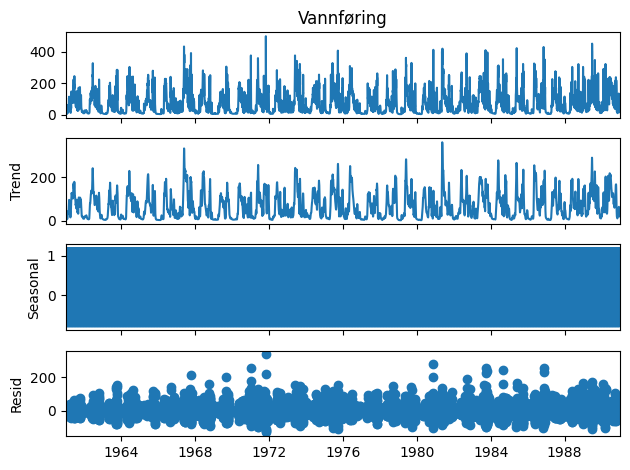

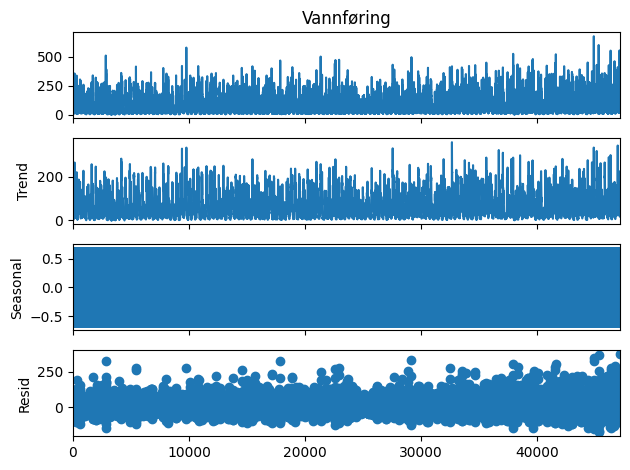

In [57]:
# In some cases, a simple decomposition using moving averages can already be informative
# here, assuming an additive model: Y[t] = T[t] + S[t] + e[t]
# and a 12-months periodicity
decomposition=seasonal_decompose(vf1['Vannføring'], model='additive', period=12).plot()
decomposition=seasonal_decompose(vf2['Vannføring'], model='additive', period=12).plot()

decomposition=seasonal_decompose(vf['Vannføring'], model='additive', period=12).plot()

#this decomposition can be regarded as a model that produces the observed data

In [44]:
from statsmodels.sandbox.stats.runs import runstest_1samp

z, p_value = runstest_1samp(vf1['Vannføring'], cutoff='mean', correction=False)
print(f'Runstest for vf1 (1991-2020): z={z}, p-value={p_value}')
z, p_value = runstest_1samp(vf2['Vannføring'])
print(f'Runstest for vf2 (1961-1990): z={z}, p-value={p_value}')

Runstest for vf1 (1991-2020): z=-88.54675699266188, p-value=0.0
Runstest for vf2 (1961-1990): z=-93.17609907225244, p-value=0.0


                            OLS Regression Results                            
Dep. Variable:             Vannføring   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     45.90
Date:                Fri, 31 Oct 2025   Prob (F-statistic):           1.31e-11
Time:                        13:03:16   Log-Likelihood:                -62877.
No. Observations:               10957   AIC:                         1.258e+05
Df Residuals:                   10955   BIC:                         1.258e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3702.4061    557.043     -6.647      

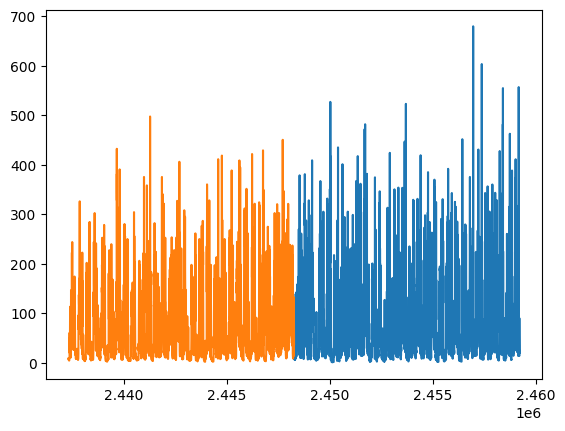

In [59]:
#Test linerairy

vf1['julian_date'] = vf1.index.to_julian_date()
vf1.head()

from statsmodels.formula.api import ols

plt.plot(vf1['julian_date'], vf1['Vannføring'])

model = ols("Vannføring ~ julian_date", vf1).fit()
print(model.summary())

vf2['julian_date'] = vf2.index.to_julian_date()
vf2.head()

from statsmodels.formula.api import ols

plt.plot(vf2['julian_date'], vf2['Vannføring'])

model = ols("Vannføring ~ julian_date", vf2).fit()
print(model.summary())

In [46]:
#%pip install hydropy hydrobox

# Compatibility shim: some older packages expect pandas.datetools which was removed in recent pandas.
# Attach pandas.tseries (or a simple namespace) to pd.datetools so imports like "import pandas.datetools"
# don't raise AttributeError.
if not hasattr(pd, 'datetools'):
	try:
		pd.datetools = pd.tseries
	except Exception:
		import types
		pd.datetools = types.SimpleNamespace()

import hydropy as hp
import hydrobox as hb

#### 1) Can we see a change in the hydrologic regime of Voss the past 30 years, compared to the previous normal period? 

##### Calculate basic statistic: yearly and monthly? 
##### Determine high and low flow pulses: 75 % for high flow and 25 % for low flow.
##### Determine high and low flow durations. 
##### Libraries: HydroBox / Hydropy

# Reset index to make Tidspunkt a column
vf1 = vf1.reset_index()
vf1['Tidspunkt'] = pd.to_datetime(vf1['Tidspunkt']).dt.tz_localize(None)
vf1.set_index('Tidspunkt', inplace=True)
print(vf1.index.tz)

vf2 = vf2.reset_index()
vf2['Tidspunkt'] = pd.to_datetime(vf2['Tidspunkt']).dt.tz_localize(None)
vf2.set_index('Tidspunkt', inplace=True)
print(vf2.index.tz)

#Libraries
myflowserie = hp.HydroAnalysis(vf1['Vannføring'])
myflowserie2 = hp.HydroAnalysis(vf2['Vannføring'])

#print(myflowserie.head())
#print(myflowserie2.head())

print("Period 1:", myflowserie.data.groupby('season').mean())
print("Period 2:", myflowserie2.data.groupby('season').mean())

print("Period 1:", myflowserie.data.groupby('season').max())
print("Period 2:", myflowserie2.data.groupby('season').max())

print("Period 1:", myflowserie.data.groupby('season').min())
print("Period 2:", myflowserie2.data.groupby('season').min())
#myflowserie.get_year('2009').get_season('summer').plot(figsize=(12,6))


# Convert pandas DataFrame to hydropy Series
#ts = hp.HySeries(vf1['Vannføring'], index=vf1.index)

# Now you can use hydropy methods
#ts_2011 = ts.get_year('2011')
#ts_2011_jun = ts_2011.get_month("Jun")
#ts_2011_jun.get_recess()

#season = get_season(vf1.index.month)  # Function to determine season based on month
#vf1['Season'] = season


None
None
Period 1:         Vannføring
season            
Autumn   72.395142
Spring   70.743714
Summer  108.595769
Winter   33.890044
Period 2:         Vannføring
season            
Autumn   79.106259
Spring   62.035638
Summer  106.688236
Winter   26.605363
Period 1:         Vannføring
season            
Autumn    679.9560
Spring    472.0458
Summer    482.0541
Winter    603.6876
Period 2:         Vannføring
season            
Autumn    497.7578
Spring    432.4957
Summer    450.6540
Winter    375.5718
Period 1:         Vannføring
season            
Autumn    3.811614
Spring    1.589425
Summer    9.052363
Winter    1.118469
Period 2:         Vannføring
season            
Autumn    5.059705
Spring    2.575216
Summer    8.447149
Winter    2.159341


In [47]:
#Flood frequency analysis
#First I need to extract annual maximum series for both time periods
vf1_annual_max = vf1.resample('Y').max()
vf2_annual_max = vf2.resample('Y').max()

print("\nAnnual maximum series for vf1 (1991-2020):")
print(vf1_annual_max)
#print("\nAnnual maximum series for vf2 (1961-1990):")
#print(vf2_annual_max)


Annual maximum series for vf1 (1991-2020):
            Vannføring  Korrigert  Kontrollert   julian_date
Tidspunkt                                                   
1991-12-31    378.8810          0            3  2.448622e+06
1992-12-31    381.2014          0            3  2.448988e+06
1993-12-31    409.1957          0            3  2.449353e+06
1994-12-31    367.3086          1            3  2.449718e+06
1995-12-31    527.2595          0            3  2.450083e+06
1996-12-31    435.2886          3            3  2.450449e+06
1997-12-31    401.3185          1            3  2.450814e+06
1998-12-31    305.4669          1            3  2.451179e+06
1999-12-31    417.6705          2            3  2.451544e+06
2000-12-31    482.0541          0            3  2.451910e+06
2001-12-31    374.8243          3            3  2.452275e+06
2002-12-31    346.5891          3            3  2.452640e+06
2003-12-31    424.3257          0            3  2.453005e+06
2004-12-31    354.0886          0        

After sorting:
            Vannføring  Korrigert  Kontrollert   julian_date    Sorted
Tidspunkt                                                             
2014-12-31    679.9560          3            3  2.457023e+06  679.9560
2015-12-31    603.6876          0            3  2.457388e+06  603.6876
2020-12-31    557.1242          0            3  2.459214e+06  557.1242
2018-12-31    555.0414          1            3  2.458484e+06  555.0414
1995-12-31    527.2595          0            3  2.450083e+06  527.2595

After adding ranks:
            Vannføring  Korrigert  Kontrollert   julian_date    Sorted  Rank
Tidspunkt                                                                   
2014-12-31    679.9560          3            3  2.457023e+06  679.9560     1
2015-12-31    603.6876          0            3  2.457388e+06  603.6876     2
2020-12-31    557.1242          0            3  2.459214e+06  557.1242     3
2018-12-31    555.0414          1            3  2.458484e+06  555.0414     4
1995-

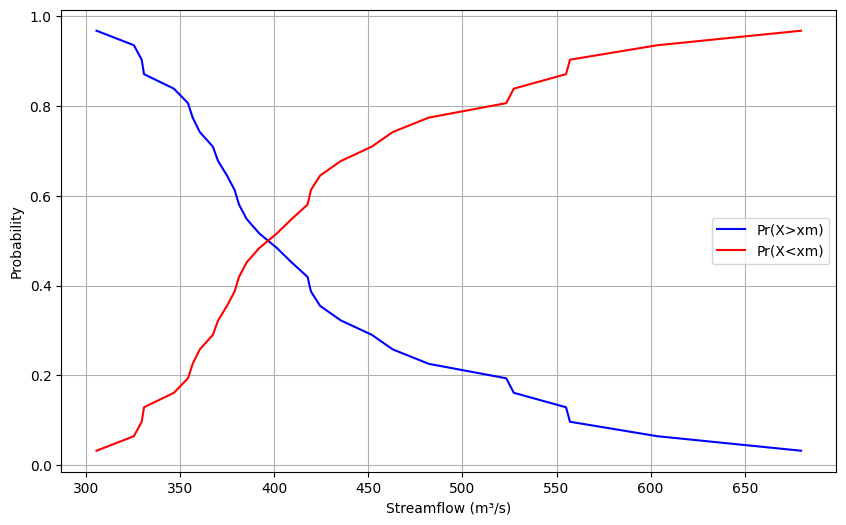

In [48]:
#vf1_annual_max: 19901-2020

# Sort the values and create a new sorted series
sorted_values = vf1_annual_max['Vannføring'].sort_values(ascending=False)
#vf1_annual_max['sorted_values'] = vf1_annual_max['Vannføring'].sort_values(ascending=False)
vf1_annual_max = vf1_annual_max.sort_values(by='Vannføring', ascending=False)
vf1_annual_max['Sorted'] = sorted_values.values
print("After sorting:")
print(vf1_annual_max.head())

# Add ranks
vf1_annual_max["Rank"] = np.arange(1,31,1)
print("\nAfter adding ranks:")
print(vf1_annual_max.head())

#Weibull probability 
N = 30
vf1_annual_max["Prob"] = vf1_annual_max["Rank"]/(N+1)
print("\nAfter adding probabilities:")
print(vf1_annual_max.head())

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(vf1_annual_max["Sorted"], vf1_annual_max["Prob"], 'b-', label='Pr(X>xm)')
plt.plot(vf1_annual_max["Sorted"], 1 - vf1_annual_max["Prob"], 'r-', label='Pr(X<xm)')
plt.ylabel("Probability")
plt.xlabel("Streamflow (m³/s)")
plt.grid(True)
plt.legend()
plt.show()

#The highest flood recordet has a prob of 0.033, meaning a return period of 30 years.. 



After sorting:
            Vannføring  Korrigert  Kontrollert   julian_date    Sorted
Tidspunkt                                                             
1971-12-31    497.7578          0            3  2.441317e+06  497.7578
1989-12-31    450.6540          3            3  2.447892e+06  450.6540
1967-12-31    432.4957          0            3  2.439856e+06  432.4957
1986-12-31    429.3181          0            3  2.446796e+06  429.3181
1985-12-31    421.9361          0            3  2.446431e+06  421.9361

After adding ranks:
            Vannføring  Korrigert  Kontrollert   julian_date    Sorted  Rank
Tidspunkt                                                                   
1971-12-31    497.7578          0            3  2.441317e+06  497.7578     1
1989-12-31    450.6540          3            3  2.447892e+06  450.6540     2
1967-12-31    432.4957          0            3  2.439856e+06  432.4957     3
1986-12-31    429.3181          0            3  2.446796e+06  429.3181     4
1985-

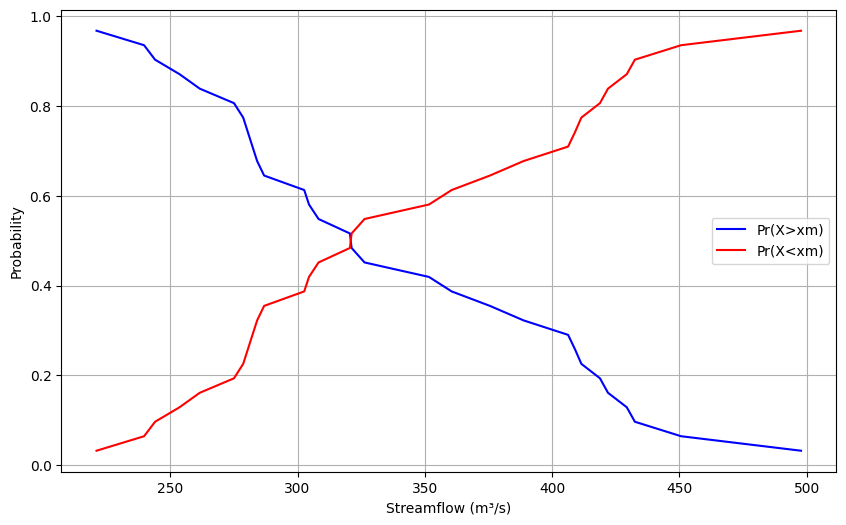

In [49]:
#vf2_annual_max: 1960-2091

# Sort the values and create a new sorted series
sorted_values = vf2_annual_max['Vannføring'].sort_values(ascending=False)
#vf1_annual_max['sorted_values'] = vf1_annual_max['Vannføring'].sort_values(ascending=False)
vf2_annual_max = vf2_annual_max.sort_values(by='Vannføring', ascending=False)
vf2_annual_max['Sorted'] = sorted_values.values
print("After sorting:")
print(vf2_annual_max.head())

# Add ranks
vf2_annual_max["Rank"] = np.arange(1,31,1)
print("\nAfter adding ranks:")
print(vf2_annual_max.head())

#Weibull probability 
N = 30
vf2_annual_max["Prob"] = vf2_annual_max["Rank"]/(N+1)
print("\nAfter adding probabilities:")
print(vf2_annual_max.head())

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(vf2_annual_max["Sorted"], vf2_annual_max["Prob"], 'b-', label='Pr(X>xm)')
plt.plot(vf2_annual_max["Sorted"], 1 - vf2_annual_max["Prob"], 'r-', label='Pr(X<xm)')
plt.ylabel("Probability")
plt.xlabel("Streamflow (m³/s)")
plt.grid(True)
plt.legend()
plt.show()

#The highest flood recordet has a prob of 0.033, meaning a return period of 30 years..?



In [50]:
#Frequency factor method
# Magnitude of 100-yr flow = 0.01

# 1) ... using Normal distribution
#Find mean and std from data: 
skew1 = stats.skew(vf1_annual_max["Vannføring"])
skew2 = stats.skew(vf2_annual_max["Vannføring"])
print("The skewness of the period from 1921-1990 data is:", skew1)
print("The skewness of the period from 1961-1990 data is:", skew2)

#Period 1: VF1 = 1.12
mean = vf1_annual_max["Vannføring"].mean()
std = vf1_annual_max["Vannføring"].std()

Kt_list = [1.341, 2.006, 3.087]

Qt_normal_list = []  # store results

for Kt in Kt_list:
    Qt_normal = mean + (Kt * std)  # compute flood discharge for each Kt
    Qt_normal_list.append(Qt_normal)

print("Period1: Flood discharge estimates for a 10 year flood:", Qt_normal_list[0], "25 year flood", Qt_normal_list[1], "50 year flood", Qt_normal_list[2])

#VF2 = 0.33
mean = vf2_annual_max["Vannføring"].mean()
std = vf2_annual_max["Vannføring"].std()
Kt_list = [1.309, 1.849, 2.211]

Qt_normal_list = []  # store results

for Kt in Kt_list:
    Qt_normal = mean + (Kt * std)  # compute flood discharge for each Kt
    Qt_normal_list.append(Qt_normal)

print("Period2: Flood discharge estimates for a 10 year flood:", Qt_normal_list[0], "25 year flood", Qt_normal_list[1], "50 year flood", Qt_normal_list[2])

# 2) ... using Log-normal distribution
# Period 1: 
log_data = np.log(vf1_annual_max["Vannføring"])
log_mean = log_data.mean()
log_std = log_data.std()

Kt_list = [1.341, 2.006, 3.087]

Qt_lognormal_list = []  # store results

for Kt in Kt_list:
    Qt_lognormal = log_mean + (Kt * log_std)
    Qt_lognormal_normal = math.exp(Qt_lognormal)
    Qt_lognormal_list.append(Qt_lognormal_normal)
print("Period1 (log-normal): Flood discharge estimates for a 10 year flood:", Qt_lognormal_list[0], "25 year flood", Qt_lognormal_list[1], "50 year flood", Qt_lognormal_list[2])

#Period 2: 
log_data = np.log(vf2_annual_max["Vannføring"])
log_mean = log_data.mean()
log_std = log_data.std()

Kt_list = [1.309, 1.849, 2.211]

Qt_lognormal_list = []  # store results

for Kt in Kt_list:
    Qt_lognormal = log_mean + (Kt * log_std)
    Qt_lognormal_normal = math.exp(Qt_lognormal)
    Qt_lognormal_list.append(Qt_lognormal_normal)
print("Period2 (log-normal): Flood discharge estimates for a 10 year flood:", Qt_lognormal_list[0], "25 year flood", Qt_lognormal_list[1], "50 year flood", Qt_lognormal_list[2])

#3) Extreme-value type I (Gumbel) distribution
#Calculate Kt for Gumbel distribution
#Period 1:

mean = vf1_annual_max["Vannføring"].mean()
std = vf1_annual_max["Vannføring"].std()

def calculate_K_T(T):
    if T <= 1:
        raise ValueError("T must be greater than 1 to avoid division by zero.")
    inner_ln = math.log(T / (T - 1))
    outer_ln = math.log(inner_ln)
    K_T = - (math.sqrt(6) / math.pi) * (0.5772156649 + outer_ln)
    return K_T

Kt_gumbel_10 = calculate_K_T(10)
Kt_gumbel_25 = calculate_K_T(25)
Kt_gumbel_50 = calculate_K_T(50)

Qt_gumbel_10 = mean + (Kt_gumbel_10 * std)
Qt_gumbel_25 = mean + (Kt_gumbel_25 * std)
Qt_gumbel_50 = mean + (Kt_gumbel_50 * std)

print("Period1 (Gumbel): 10-yr:", Qt_gumbel_10, "25-yr:", Qt_gumbel_25, "50-yr:", Qt_gumbel_50)

#Period 2:
mean = vf2_annual_max["Vannføring"].mean()
std = vf2_annual_max["Vannføring"].std()

Kt_gumbel_10 = calculate_K_T(10)
Kt_gumbel_25 = calculate_K_T(25)
Kt_gumbel_50 = calculate_K_T(50)

Qt_gumbel_10 = mean + (Kt_gumbel_10 * std)
Qt_gumbel_25 = mean + (Kt_gumbel_25 * std)
Qt_gumbel_50 = mean + (Kt_gumbel_50 * std)

print("Period2 (Gumbel): 10-yr:", Qt_gumbel_10, "25-yr:", Qt_gumbel_25, "50-yr:", Qt_gumbel_50)

# 4) ... using Pearson III distribution

alfa = vf1_annual_max["Vannføring"].mean()
beta = vf1_annual_max["Vannføring"].std()
X = vf1_annual_max["Vannføring"]
n = 30

def cs(X, alfa, beta):
   
    numerator = n * np.sum((X - alfa) ** 3)
    denominator = (n - 1) * (n - 2) * (beta ** 3)

    return numerator / denominator

cs(X,alfa,beta)

Kt_list = [1.341, 2.006, 3.087]

Qt_pearson_list = []  # store results

for Kt in Kt_list:
    Qt_pearson = alfa + (Kt * beta)  # compute flood discharge for each Kt
    Qt_pearson_list.append(Qt_normal)

print("Period1 (Pearson): Flood discharge estimates for a 10 year flood:", Qt_normal_list[0], "25 year flood", Qt_normal_list[1], "50 year flood", Qt_normal_list[2])



The skewness of the period from 1921-1990 data is: 1.1217151875514948
The skewness of the period from 1961-1990 data is: 0.3302574027154459
Period1: Flood discharge estimates for a 10 year flood: 544.4889261556203 25 year flood 604.4284207194937 50 year flood 701.8638998526474
Period2: Flood discharge estimates for a 10 year flood: 434.5935305194265 25 year flood 474.3658123227041 50 year flood 501.02797160564194
Period1 (log-normal): Flood discharge estimates for a 10 year flood: 541.4126204043281 25 year flood 617.4865526621984 50 year flood 764.6202363068162
Period2 (log-normal): Flood discharge estimates for a 10 year flood: 439.3629333476923 25 year flood 494.089931934871 50 year flood 534.5437076380546
Period1 (Gumbel): 10-yr: 541.2036108359204 25-yr: 607.8385475442026 50-yr: 657.2721501653807
Period2 (Gumbel): 10-yr: 434.26585104705566 25-yr: 488.7157786285794 50-yr: 529.1098454016994
Period1 (Pearson): Flood discharge estimates for a 10 year flood: 434.5935305194265 25 year flo

In [ ]:
#But... does it really make sense to do flood frequency analysis on only 30 years of data? Or should we all data including 1961-1990 and then compare with results when including  period from 1991-2020? 
#Ask Kolbjørn...?

In [ ]:
#What is the probability of getting 4 (or 5) 20 year flood in 8 years? 
#For Voss er det ventet at flomvannføringene vil øke med 40 prosent i år 2100.

In [ ]:
from scipy.stats import binom

n = 8  # number of trials (years)
p = 1/20  # probability of success (20-year flood in a given year)
k = 5 # number of successes (floods)
i_5floods = binom.pmf(k, n, p)

print(i_5floods)


1.50040625e-05


#### I analysen over har vi bare brukt maks pr år, men... 
#### Hva om vi bruker alle flomverdier over middelflom? 
#### Flomfrekvensanalyse å dette datasettet. 
#### Se om det er en trend over perioden. 
#### Snittmaks flom, 

ML

Hvilke dataperioder skal vi trene på? 

Plukke ut tilfeldig år som dekker alle pentiler (5)
70/30: 70 trening, 30 test

Trenger vi andre data? 
- mengde nedbør i nedbørfelt
- temperatur alle
- snødybde/snøsmelting

LSTM: Long short-term memory

Ulike datatyper: gts nve (grid time series)
Nevina/regine: definere nedbørfelt
Plukke gridpunkter i nedbørfeltet
Må ha kontinuerlige verdier. 